<a href="https://colab.research.google.com/github/janosepah/ML_Project/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Electricity Supply and Demand
Team Members (alphabetical order):
-	Samarah Azimpoor
-	Safoura Janosepah


# Power Data Source - IESO

## Market Demand
### Market Demand Definitions and Graphs
The graph below plots values for both Total Market Demand and Ontario Demand.

- **Total Market Demand** represents the total energy that was supplied from the IESO-Administered Market.

The IESO calculates Total Market Demand by summing all output from generators registered in the Market plus all scheduled imports to the province. It is also equal to the sum of all load supplied from the Market plus exports from the province, plus all line losses incurred on the IESO-controlled grid.

- **Ontario Demand** represents the total energy that was supplied from the IESO-Administered Market for the purpose of supplying load within Ontario.

It is also equal to the sum of all loads within Ontario which is supplied from the Market, plus all line losses incurred on the IESO-controlled grid.


In [1]:
# Libraries:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
# Set default plot styles
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14

In [2]:
# Load Data 
Data_Path = 'https://raw.githubusercontent.com/janosepah/ML_Project/master/Data/'


In [3]:
Ontario_Demand = pd.read_csv(Data_Path + 'PUB_Demand_2017.csv', parse_dates=['Date'])
Ontario_Demand.set_index(['Date'], inplace=True)
Ontario_Demand.head()

,Hour,Market Demand,Ontario Demand
Date,,,
2017-01-01,1,17172,13522
2017-01-01,2,16757,13117
2017-01-01,3,16370,12816
2017-01-01,4,16075,12605
2017-01-01,5,16050,12563


In [4]:
Ontario_Demand.shape

(8760, 3)

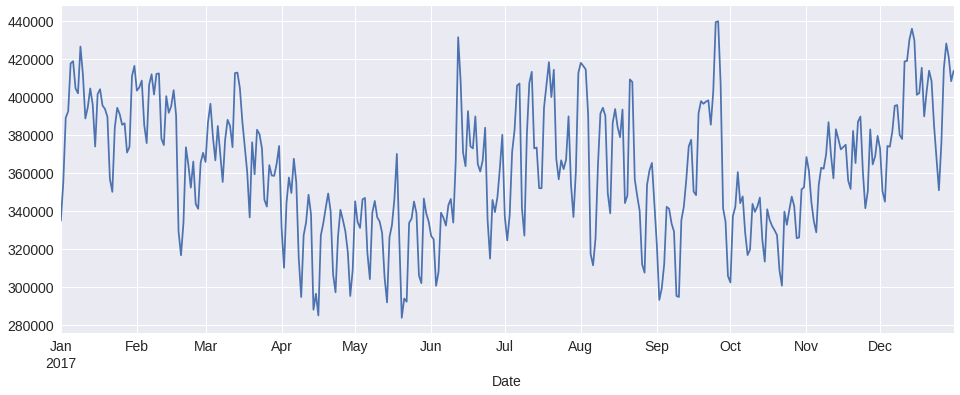

In [12]:
daily_data = Ontario_Demand.resample(rule='D').sum()
daily_data = daily_data.asfreq('D')
daily_data.head(10)
daily_data['Ontario Demand'].plot();

In [8]:
#Now there's a tail end where it's not a full day, so it's dropping off.

#For our purposes, we will just delete that part day.

daily_data = daily_data.drop([daily_data.index.min(), daily_data.index.max()])

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import DateFormatter

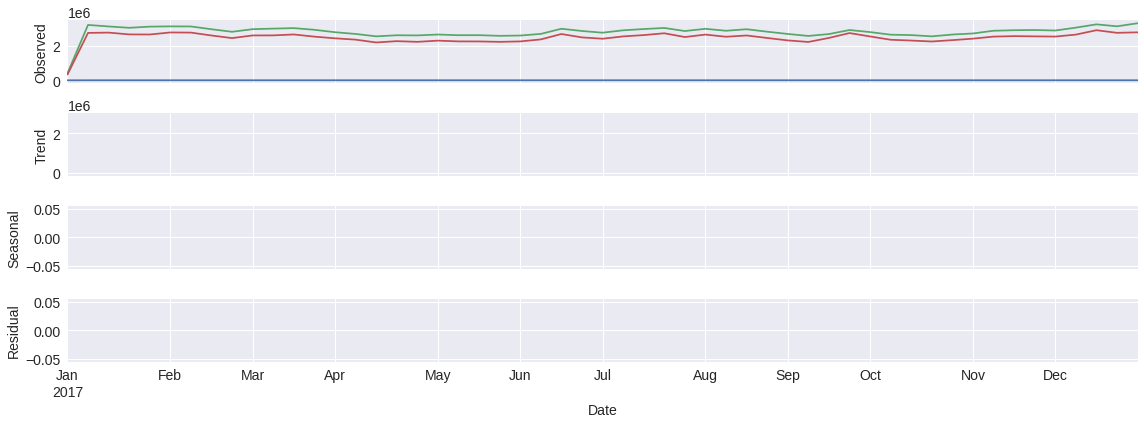

In [15]:
weekly_data = Ontario_Demand.resample(rule='W').sum()
decomposition = seasonal_decompose(weekly_data, model='additive') # Aggregate to weekly level

fig = decomposition.plot()
plt.show()